## Modelling

This notebook contains different models investigated as alternatives for predicting the air quality index.
* ARIMA model for baseline model
* Stacked LSTM model using only air quality index time series
* Stacked LSTM model using also weather data

In [78]:
from math import ceil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout



In [13]:
df = pd.read_parquet("data/air-quality-idx-train.parquet.gzip")
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Timestamp,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
0,2014-01-01 01:00:00,78.0,1016.8,89.0,0.0,5.1,253.0,4.9
1,2014-01-01 02:00:00,68.0,1016.8,87.0,0.0,5.1,255.0,5.6
2,2014-01-01 03:00:00,60.0,1016.9,85.0,0.0,5.2,246.0,5.3
3,2014-01-01 04:00:00,48.0,1016.9,86.0,0.0,5.2,254.0,5.7
4,2014-01-01 05:00:00,51.0,1017.1,89.0,0.0,5.1,249.0,4.3


In [14]:
df.dtypes

Timestamp                   datetime64[ns]
Mannerheimintie                    float64
Air pressure (msl) (hPa)           float64
Relative humidity (%)              float64
Rain intensity (mm/h)              float64
Air temperature (degC)             float64
Wind direction (deg)               float64
Wind speed (m/s)                   float64
dtype: object

In [15]:
# code from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARIMA
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Baseline model: ARIMA

In order to get a baseline for prediction error let's define an Autoregressive Integrated Moving Average (ARIMA) model for air quality index time serie. 

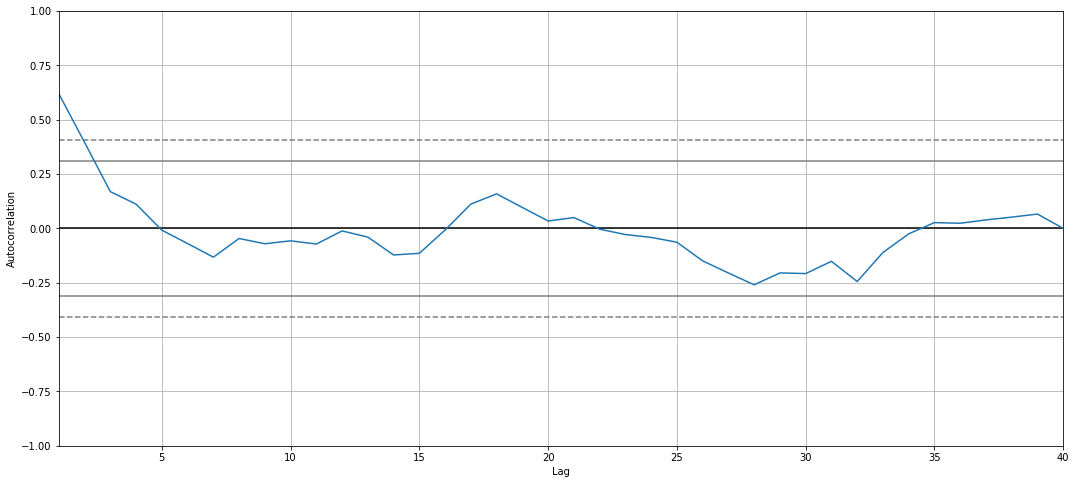

In [16]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:40])

As we found out in the data exploration 2-3 previous values are correlated with a current entry (see plot above). Therefore let's vary the lag size parameter between 0-3 and search for the best model.

In [23]:
best_aic = np.inf 
best_order = None
best_mdl = None
pq_rng = [3,4,5]
d_rng = [1,2]

for i in pq_rng:
    for d in d_rng:
        try:
            tmp_mdl = ARIMA(df["Mannerheimintie"], order=(i,d,0)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, d, 0)
                best_mdl = tmp_mdl
        except: continue
print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))


aic: 318420.75 | order: (5, 1, 0)


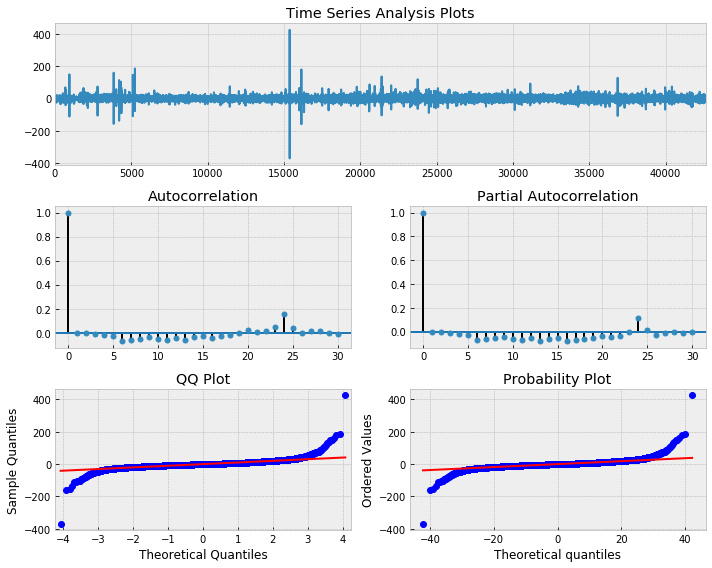

In [24]:
_ = tsplot(best_mdl.resid, lags=30)

So best ARIMA model is defined with parameters: (5,1,0). Let's try this out by running 50 consequtive fit & predict next value cycles and measure MSE

Test MSE: 83.266


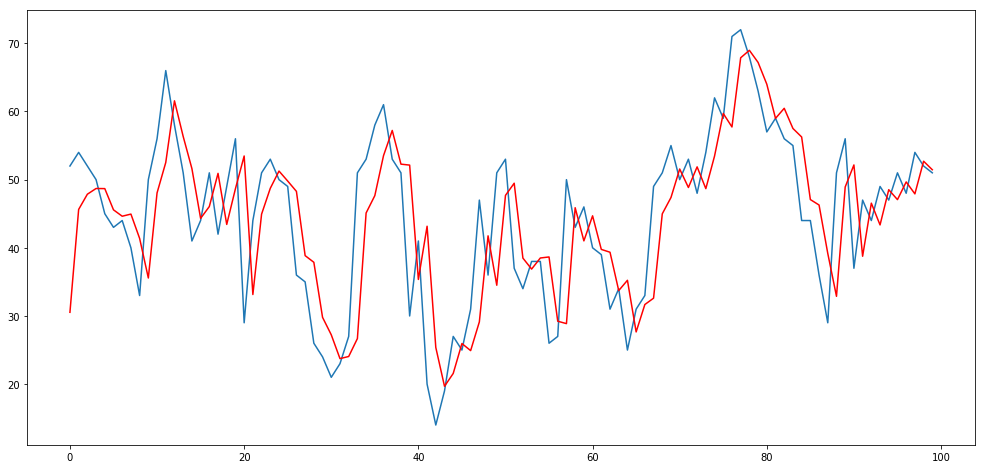

In [25]:
data = df["Mannerheimintie"].values
size = int(len(data) - 100)
train, test = data[0:size], data[size:]
history = train.tolist()
predictions = list()

for t in range(len(test)):
    try:
        model = ARIMA(history, order=(5,1,0)).fit(method='mle', trend='nc')
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    except:
        continue
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Deep learning model: LSTM

let's first investigate a stacked LSTM that only uses the air quality index to predict the next values. In addition we would like to investigate how the model accuracy changes depending on the lag size.

Therefore let's train three different models and compare their accuracy with MSE.

In [84]:
# we only have a single feature
features = 1
test_len = 200

# prepare data & normalize with robust scaler
series = df["Mannerheimintie"].values.reshape((len(df["Mannerheimintie"]), features))
scaler = RobustScaler()
series = scaler.fit_transform(series)

# split into train and test sets
train_size = int(len(series) - test_len)
test_size = len(series) - train_size
train, test = series[0:train_size,:], series[train_size:len(series),:]
steps_per_epoch = ceil(train_size/64)

results = []
for i in [1, 3, 5]:
    train_generator = TimeseriesGenerator(train, train, length=i, batch_size=64)
    test_generator = TimeseriesGenerator(test, test, length=i, batch_size=64)
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(i, features), return_sequences=True))
    model.add(LSTM(50, activation='relu', dropout=0.3, input_shape=(i, features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    # fit model
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, verbose=0)
    # test with test data
    yhat = model.predict_generator(test_generator)
    # calculate MSE
    test_data = scaler.inverse_transform(test[:len(yhat)])
    predictions = scaler.inverse_transform(yhat)
    error = mean_squared_error(test_data, predictions)
    print("Look back: {}, MSE: {}".format(i, error))
    results.append((i, test_data, predictions, error, model))



Look back: 1, MSE: 7.80912615718812
Look back: 3, MSE: 126.06171673068529
Look back: 5, MSE: 235.2509565603799


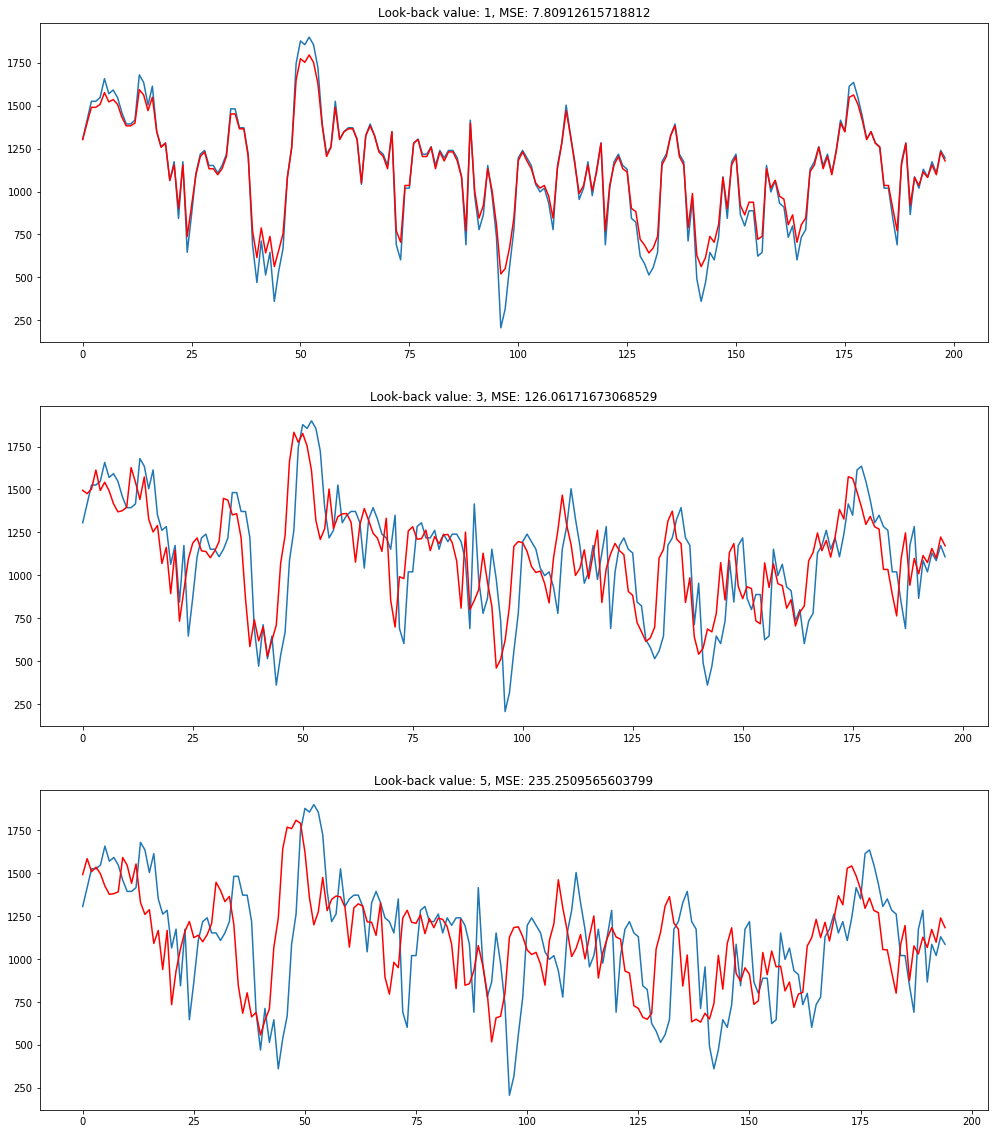

In [87]:
plt.figure(figsize=(17,20))
k = 1
for (i, test_data, yhat, error, model) in results:
    plt.subplot(3, 1, k)
    plt.plot(scaler.inverse_transform(test_data))
    plt.plot(scaler.inverse_transform(yhat), color='red')
    plt.title("Look-back value: {}, MSE: {}".format(i, error))
    k = k + 1

Based on the different models the most accurate one uses only one previous air quality index value as a predictor for the future values. This model achieves exceptionally good MSE. It might be overfitting but let's store this model for model evaluation.

In [88]:
_, _, _, _, model = results[0]
model.save("models/lstm-look-back-1.h5")

## Use weather data with LSTM

Next let's include weather data into the feature set and do similar trial regarding the lag size.

In [95]:
# this time we'llhave 7 features: air quality index + weather data
features=7
test_len = 200
steps_per_epoch = ceil(train_size/64)

# prepare data into supervised learning problem by separating X and y
y = df["Mannerheimintie"].shift(-1).values
y = y[~np.isnan(y)]
y = y.reshape(-1, 1)

X = df.drop("Timestamp", axis=1)
X.drop(X.tail(1).index,inplace=True) 
X = X.values

scaler_X = RobustScaler()
X = scaler_X.fit_transform(X)
scaler_y = RobustScaler()
y = scaler_y.fit_transform(y)

# split into train and test sets
train_size = int(len(y) - test_len)
test_size = len(y) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]

results = []
for i in [2, 4, 8]:
    train_generator = TimeseriesGenerator(train_X, train_y, length=i, batch_size=64)
    test_generator = TimeseriesGenerator(test_X, test_y, length=i, batch_size=64)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(i, features), return_sequences=True))
    model.add(LSTM(50, activation='relu', dropout=0.3, input_shape=(i, features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    # fit model
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, verbose=0)
    
     # test with test data
    yhat = model.predict_generator(test_generator)
    # calculate MSE
    test_data = scaler_y.inverse_transform(test_y[:len(yhat)])
    predictions = scaler_y.inverse_transform(yhat)
    error = mean_squared_error(test_data, predictions)
    print("Look back: {}, MSE: {}".format(i, error))
    results.append((i, test_data, predictions, error, model))

Look back: 2, MSE: 26.814489490667274
Look back: 4, MSE: 117.2675134679403
Look back: 8, MSE: 296.955777540021


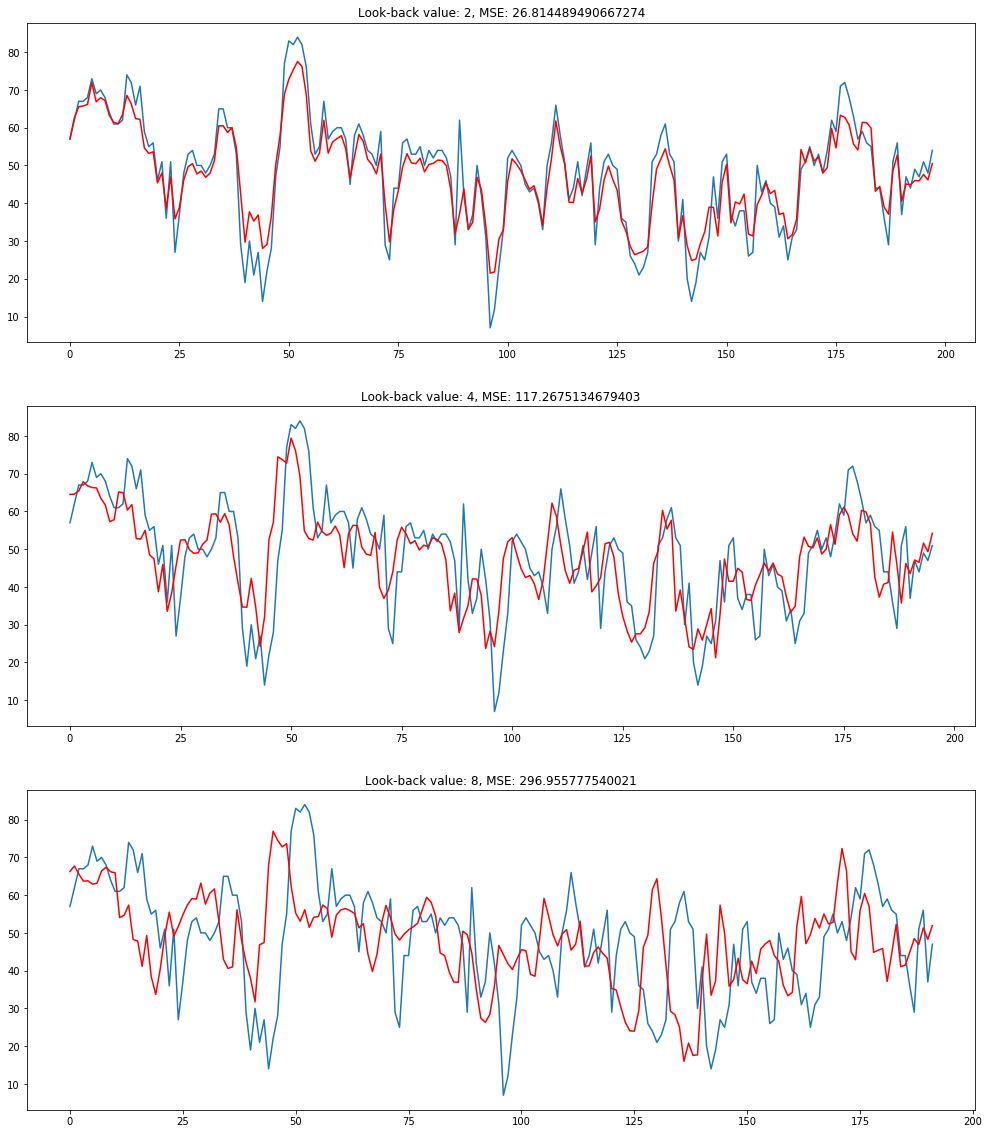

In [101]:
plt.figure(figsize=(17,20))
k = 1
for (i, test_data, yhat, error, model) in results:
    plt.subplot(3, 1, k)
    plt.plot(scaler_y.inverse_transform(test_y[:len(yhat)]))
    plt.plot(yhat, color='red')
    plt.title("Look-back value: {}, MSE: {}".format(i, error))
    k = k + 1

Again it looks like that the smallest lag value performs the best. So let's save this model for evaluation.

In [102]:
_, _, _, _, model = results[0]
model.save("models/lstm-weather-data-look-back-1.h5")